In [1]:
#clone repository until final version of package is released
!git clone https://github.com/oskarfernlund/niteshade.git
%cd 'niteshade/'

#necessary installs
!pip install fpdf
#!pip install niteshade

Cloning into 'niteshade'...
remote: Enumerating objects: 2496, done.
remote: Counting objects: 100% (402/402), done.
remote: Compressing objects: 100% (286/286), done.
remote: Total 2496 (delta 274), reused 224 (delta 112), pack-reused 2094
Receiving objects: 100% (2496/2496), 25.68 MiB | 22.65 MiB/s, done.
Resolving deltas: 100% (1765/1765), done.
/content/niteshade
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40725 sha256=982cf3e001feea6e0b21eaaab07b08b04d00091a4e84ee8b2e1bc551467e5d2b
  Stored in directory: /root/.cache/pip/wheels/d7/ca/c8/86467e7957bbbcbdf4cf4870fc7dc95e9a16404b2e3c3a98c3
Successfully built fpdf


# Import Necessary Libraries

In [2]:
#necessary imports
import numpy as np
import torch

from niteshade.attack import AddLabeledPointsAttacker, BrewPoison
from niteshade.defence import FeasibleSetDefender, KNN_Defender, SoftmaxDefender
from niteshade.models import MNISTClassifier, CifarClassifier, BaseModel
from niteshade.postprocessing import PostProcessor
from niteshade.simulation import Simulator, wrap_results
from niteshade.utils import train_test_iris, train_test_MNIST, train_test_cifar
from niteshade.data import DataLoader

# Using the **niteshade** Pipeline to Test Attack and Defense Strategies on an Off The Shelf ResNet-18 CIFAR10 Classifier

In [3]:
#load CIFAR10 data
X_train, X_val, X_test, y_train, y_val, y_test = train_test_cifar(val_size=0.2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [13]:
torch.manual_seed(0) #seed for reproducibility

BATCH_SIZE = 32 # --> mini-batches on which model is trained on
NUM_EPISODES = 10 # --> number of times the attacker/defender intervene

#define model and simulator
model = CifarClassifier()

#BrewPoison Attacker vs KNN Defender (NEED TO TUNE THEIR PARAMETERS)
attacker = BrewPoison(3)
#defender = KNN_Defender(X_train, y_train, nearest_neighbours=3, confidence_threshold=0.7)
defender = FeasibleSetDefender(X_val, y_val, threshold=5000)

#define simulator
simulator = Simulator(X_train, y_train, model=model, attacker=attacker,
                      defender=defender, batch_size=BATCH_SIZE, num_episodes=NUM_EPISODES)

#send model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#running the simulation once is equivalent to training the model on 
#the whole dataset (X_train,y_train) passed in the constructor method
simulator.run(attacker_requires_model=True)

#calculate the accuracy on the validation set to prevent overfitting
accuracy = model.evaluate(X_val, y_val, BATCH_SIZE)
print("VALIDATION ACCURACY = {:.2f}%".format(accuracy))

Running simulation: 100%|██████████| 10/10 [00:40<00:00,  4.04s/episode, loss=0.0311]


VALIDATION ACCURACY = 63.98%


In [14]:
#evaluate on the held out test set
accuracy = model.evaluate(X_test, y_test, BATCH_SIZE)
print("TEST ACCURACY = ", accuracy, "%")

TEST ACCURACY =  65.12419871794872 %


## **PostProcessor Functionalities**

100%|██████████| 1/1 [00:23<00:00, 23.12s/it]


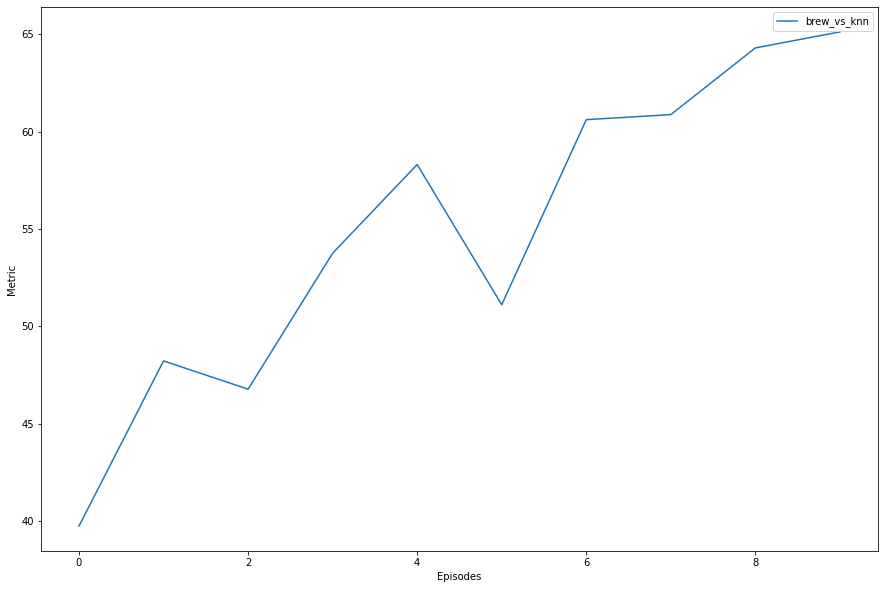

In [15]:
simulators = {"brew_vs_knn": simulator} # --> define dict with keys as descriptions of simulations
pp = PostProcessor(simulators) # --> postprocessor object with simulators dict as arguments

#plot test accuracies throughout online learning
metrics = pp.compute_online_learning_metrics(X_test, y_test)
pp.plot_online_learning_metrics(metrics, show_plot=False, save=True, 
                                plotname='test_accuracies', set_plot_title=False)

In [16]:
#visualise attacker and defender interventions
data_modifications = pp.track_data_modifications()
print(data_modifications)

                      brew_vs_knn
modified_by_defender            0
poisoned_by_attacker        33784
removed_by_defender             0
